MSE: 1719.3512869638962
R² Score: 0.6236751178272653


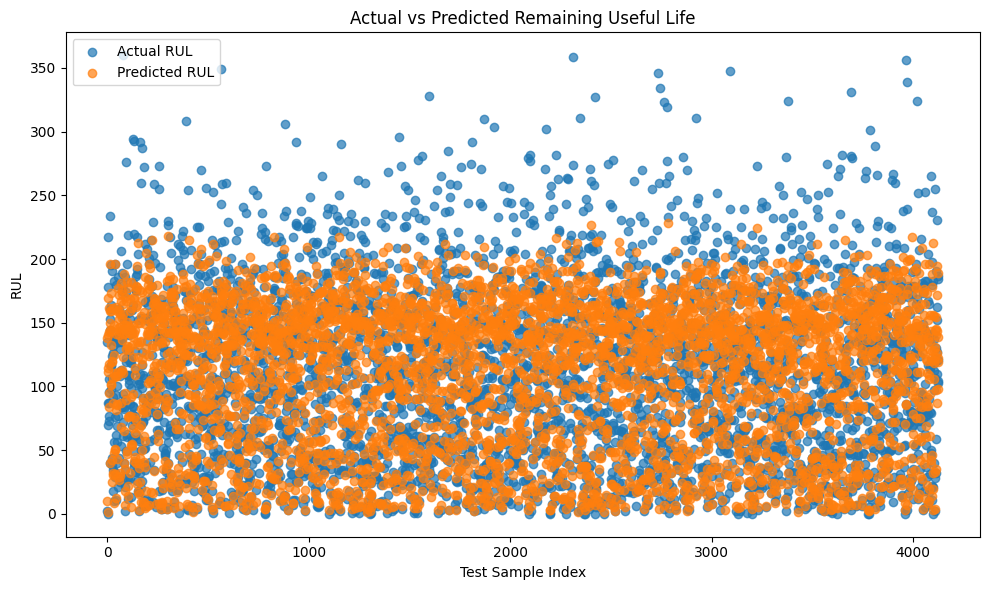

In [1]:
# Aircraft Engine RUL Prediction using FD001 from CMAPSS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load Data
column_names = ['unit', 'time', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + \
               [f'sensor_{i}' for i in range(1, 22)]

data = pd.read_csv('/content/train_FD001.txt', sep=' ', header=None)
data.drop(columns=[26, 27], inplace=True)  # Extra whitespace columns
data.columns = column_names

# Compute Remaining Useful Life (RUL)
rul_df = data.groupby('unit')['time'].max().reset_index()
rul_df.columns = ['unit', 'max_time']
data = data.merge(rul_df, on='unit')
data['RUL'] = data['max_time'] - data['time']
data.drop(columns=['max_time'], inplace=True)

# Optional: Drop constant or non-informative sensors
# e.g., sensor_1, sensor_5, sensor_10 may be constant in FD001
drop_sensors = ['sensor_1', 'sensor_5', 'sensor_10']
data.drop(columns=drop_sensors, inplace=True)

# Normalize Sensor Data
sensor_cols = [col for col in data.columns if 'sensor_' in col]
scaler = MinMaxScaler()
data[sensor_cols] = scaler.fit_transform(data[sensor_cols])

# Select last cycle of each engine (for inference or testing)
latest_cycle = data.groupby('unit').tail(1)

# Features and Labels
X = data[sensor_cols + ['operational_setting_1', 'operational_setting_2', 'operational_setting_3']]
y = data['RUL']

# Train-test split (optional: use tail of each unit only for real-world test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# Plot Predicted vs Actual RUL
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label='Actual RUL', alpha=0.7)
plt.scatter(range(len(y_pred)), y_pred, label='Predicted RUL', alpha=0.7)
plt.title("Actual vs Predicted Remaining Useful Life")
plt.xlabel("Test Sample Index")
plt.ylabel("RUL")
plt.legend()
plt.tight_layout()
plt.show()


In [2]:
# aircraft_rul_model.py

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
import os

# ========== STEP 1: LOAD AND PREPROCESS DATA ==========
# Download the CMAPSS FD001 dataset and load it
# https://www.nasa.gov/content/prognostics-center-of-excellence-data-set-repository
df = pd.read_csv("train_FD001.txt", sep=' ', header=None)
df.dropna(axis=1, inplace=True)

# Set column names
cols = ['unit_number', 'time_in_cycles',
        'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + \
       [f'sensor_{i}' for i in range(1, 22)]
df.columns = cols

# Drop unused sensors
drop_sensors = ['sensor_1', 'sensor_5', 'sensor_10']
df.drop(columns=drop_sensors, inplace=True)

# ========== STEP 2: COMPUTE RUL ==========
rul_df = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
rul_df.columns = ['unit_number', 'max_cycle']
df = df.merge(rul_df, on='unit_number', how='left')
df['RUL'] = df['max_cycle'] - df['time_in_cycles']
df.drop(columns='max_cycle', inplace=True)

# ========== STEP 3: PREPARE FEATURES ==========
feature_cols = [col for col in df.columns if col not in ['unit_number', 'time_in_cycles', 'RUL']]
X = df[feature_cols]
y = df['RUL']

# ========== STEP 4: SCALING AND SPLITTING ==========
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ========== STEP 5: MODEL TRAINING ==========
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ========== STEP 6: EVALUATION ==========
y_pred = model.predict(X_test)
print("📊 Model Performance on Test Set:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")

# ========== STEP 7: SAVE MODEL AND SCALER ==========
os.makedirs("model", exist_ok=True)
pickle.dump(model, open("model/rul_model.pkl", "wb"))
pickle.dump(scaler, open("model/scaler.pkl", "wb"))
pickle.dump(feature_cols, open("model/feature_list.pkl", "wb"))

# ========== STEP 8: PREDICT RUL FOR NEW ENGINE ==========
input_data = {
    'operational_setting_1': 0.0,
    'operational_setting_2': 0.0,
    'operational_setting_3': 100.0,
    'sensor_2': 642.82,
    'sensor_3': 1589.66,
    'sensor_4': 1405.6,
    'sensor_6': 21.61,
    'sensor_7': 39.06,
    'sensor_8': 23.28,
    'sensor_9': 100.0,
    'sensor_11': 39.0,
    'sensor_12': 23.23,
    'sensor_13': 47.47,
    'sensor_14': 522.49,
    'sensor_15': 2388.06,
    'sensor_16': 8138.48,
    'sensor_17': 8.42,
    'sensor_18': 0.03,
    'sensor_19': 391.0,
    'sensor_20': 2388.0,
    'sensor_21': 100.0
}

# Load model, scaler, and feature list
model = pickle.load(open("model/rul_model.pkl", "rb"))
scaler = pickle.load(open("model/scaler.pkl", "rb"))
feature_list = pickle.load(open("model/feature_list.pkl", "rb"))

# Convert input into DataFrame and reorder
X_input_df = pd.DataFrame([input_data])[feature_list]

# Scale and predict
X_scaled_input = scaler.transform(X_input_df)
predicted_rul = model.predict(X_scaled_input)[0]

print(f"\n🔧 Predicted Remaining Useful Life (RUL): {predicted_rul:.2f} cycles")



📊 Model Performance on Test Set:
MAE: 29.64
MSE: 1717.62
R² Score: 0.6241

🔧 Predicted Remaining Useful Life (RUL): 201.62 cycles
